In [1]:
from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
import scipy as sp
import glob
import pickle as pckl
import math
import tqdm
from collections import Counter
from sklearn import metrics

import tensorflow as tf

%matplotlib inline
%precision 4
plt.style.use('ggplot')

# DD2447: Statistical Methods in Applied Computer Science 

## Assignemnt 3

### 3.1 PyClone Light


In this problem, you should apply a collapsed Gibbs sampler in order to cluster mutations based on a Dirichlet Process Mixture Model (DPMM). The probabilistic model can, following the original publication, be described by the graphcal model in Figure 2(a), where $H$ is a Dirichlet Process (DP). We will instead use the grapical model in Figure 2(b), which yelds the same distribution when equipped with distributions as follows,


\begin{equation}
\begin{aligned}
\pi &\sim \text{Gem}(\alpha) \\
Z^n &\sim \pi \\
\phi^k &\sim H_0 = \text{Beta}(1,1) \\
b^n &\sim \text{Bin}(d^n, \phi^{Z^n})\\
\end{aligned}
\end{equation}



#### Answers:

Utility functions:

In [2]:
def beta(a,b):
    return sp.special.beta(a,b)
    #return math.exp(math.lgamma(a)*math.lgamma(b)/math.lgamma(a+b))

def softmax(p):
    p = np.exp(p - np.max(p))
    p = p / np.sum(p)
    return p

def evaluate_clustering(true_label,predicted_labels):
    rand_score    = metrics.adjusted_rand_score(true_label,predicted_labels)
    mutual_info   = metrics.adjusted_mutual_info_score(true_label, predicted_labels)
    print('rand: {} | mutual_info: {}'.format(rand_score,mutual_info))

**Question 16:** Implement an fully collapsed Gibbs sampler for this DPMM.

Dirichlet process mixture models is a representative algorithm of the class of infinite mixture models with a non-parametric prior, a family of models that do not impose any a priori bound on $K$.

The main idea is to have a method of working with an infinite amount of clusters which will be used to represent different distributions, which makes it a distribution over distributions. This can be done with a Dirichlet process, which can be in our case explaind with a stick-breaking construction. 

The method generates a infinite sequence of numbers in range from $0$ to $1$, denoted with $\beta_k$ such that $ \beta \sim Beta(1,\alpha)$ for a arbitrary parameter $\alpha$. Beta values are then used to determinate the proportions of stick length as follows:

$$ \pi_k = \beta_k \prod_{t=1}^{k-1} (1-\beta_t)$$

Another common notation is:

$$ \pi \sim GEM(\alpha) $$

We can then compute $\theta_k$ as samples comming from different segments $\pi_k$ such that:

$$ G(\theta) = \sum_{k=1}^{\infty} \pi_k \delta_{\theta_k}(\theta) $$

where $\pi \sim GEM(\alpha)$ and $\theta \sim H$. Then once can show that G id distributed as a Dirichlet process with parameters $\alpha$ and a distribution $H$, i.e.$G \sim DP(\alpha,H)$.

In our model sampled $\theta_k$ values correspond to $\phi_k$ probabilities of a successful outcome for a binomial distribution, with the number of trials being randomly generated for each sample. 

Now we will derive the conditional probability for the next cluster placement which will be used in the collapsed Gibbs sampler.

The probability of data point's cluster $z_i$ being a particular cluster $k$ is :

$$ p(z_i = k \mid \mathbf{z}_{-i}, \mathbf{b}, \mathbf{d}, \theta, \alpha) \propto p(z_i = k \mid \mathbf{z}_{-i},\alpha) p(\mathbf{b}_i \mid \mathbf{b}_{-i}, \mathbf{d}, z_i = k, \mathbf{z}_{-i}, \theta ) $$

Where we can write :

$$ p(z_i \mid \mathbf{z}_{-i}, \alpha) = 
     \begin{cases}
       \frac{N_{k,-i}}{\alpha + N -1} \text{ if k has been seen before}\\
       \frac{\alpha}{\alpha + N -1} \text{ if k is a new cluster}\\
     \end{cases} $$
     

First we will analyse the case if the cluster has been seen before. That means there are potentialy other points in observed data that are situated in the same cluster. We then procede to write:

$$ p(\mathbf{b}_i \mid \mathbf{b}_{-i},\mathbf{d}, z_i = k, \mathbf{z}_{-i}, \theta ) = p(\mathbf{b}_i \mid \mathbf{b}_{-i,k}, \mathbf{d}_k, \theta ) = \frac{p(\mathbf{b}_i,\mathbf{b}_{-i,k} \mid \mathbf{d}_k,\theta )}{p( \mathbf{b}_{-i,k} \mid \mathbf{d}_k \theta )} $$ 

$$ p(\mathbf{b}_i,\mathbf{b}_{-i,k} \mid \mathbf{d}_k,\theta ) = \int p(b_i\mid d_i,\phi^k) \left[ \sum_{j \neq i, z_j=k} p(b_j\mid d_j,\phi^k) \right] p(\phi^k \mid H_0) \text{d} \phi^k$$ 

$$ p(\mathbf{b}_i,\mathbf{b}_{-i,k} \mid \mathbf{d}_k,\theta ) = \int Bin(b_i\mid d_i,\phi^k) \left[ \sum_{j \neq i, z_j=k} Bin(b_j\mid d_j,\phi^k) \right] Beta(\phi^k \mid a=1,b=1) \text{d} \phi^k$$ 


Since the beta distribution is a conjugate prior to binomial distribution, we can write :

$$ p(\mathbf{b}_i,\mathbf{b}_{-i,k} \mid \mathbf{d}_k,\theta ) = \binom{\sum_{z_j=k} d_j}{\sum_{z_j=k} b_j} \frac{B(\sum_{z_j=k} b_j + 1 , \sum_{z_j=k} d_j - \sum_{z_j=k} b_j +1)}{B(1,1)} $$ 



Analogously :

$$ p( \mathbf{b}_{-i,k} \mid \mathbf{d}_k \theta ) = \binom{\sum_{z_j=k,j \neq i} d_j}{\sum_{z_j=k,j \neq i} b_j} \frac{B(\sum_{z_j=k,j \neq i} b_j + 1 , \sum_{z_j=k,j \neq i} d_j - \sum_{z_j=k,j \neq i} b_j +1)}{B(1,1)} $$ 

$$ p(\mathbf{b}_i \mid \mathbf{b}_{-i,k}, \mathbf{d}_k, \theta ) = \frac{\binom{\sum_{z_j=k} d_j}{\sum_{z_j=k} b_j} \frac{B(\sum_{z_j=k} b_j + 1 , \sum_{z_j=k} d_j - \sum_{z_j=k} b_j +1)}{B(1,1)}}{\binom{\sum_{z_j=k,j \neq i} d_j}{\sum_{z_j=k,j \neq i} b_j} \frac{B(\sum_{z_j=k,j \neq i} b_j + 1 , \sum_{z_j=k,j \neq i} d_j - \sum_{z_j=k,j \neq i} b_j +1)}{B(1,1)}} $$ 

$$ p(\mathbf{b}_i \mid \mathbf{b}_{-i,k}, \mathbf{d}_k, \theta ) = \frac{\binom{\sum_{z_j=k} d_j}{\sum_{z_j=k} b_j}}{\binom{\sum_{z_j=k,j \neq i} d_j}{\sum_{z_j=k,j \neq i} b_j}} \frac{B(\sum_{z_j=k} b_j + 1 , \sum_{z_j=k} d_j - \sum_{z_j=k} b_j +1)}{B(\sum_{z_j=k,j \neq i} b_j + 1 , \sum_{z_j=k,j \neq i} d_j - \sum_{z_j=k,j \neq i} b_j +1)} $$ 

For the case when the cluster was not observed before, i.e. it's a new cluster we have : 

$$ p(\mathbf{b}_i \mid \mathbf{b}_{-i},\mathbf{d}, z_i = k^*, \mathbf{z}_{-i}, \theta ) = p(b_i \mid \theta ) = \int p(b_i\mid d_i,\phi^{k^*}) p(\phi^{k^*} \mid H_0) \text{d} \phi^{k^*} $$ 

$$ p(b_i \mid \theta ) = \binom{d_i}{ b_i} \frac{B(b_i + 1 , d_i - b_i +1)}{B(1,1)} $$ 



Finaly we can put it all together to write:

$$ p(z_i = k \mid \mathbf{z}_{-i}, \mathbf{b}, \mathbf{d}, \theta, \alpha) \propto      
\begin{cases}
       \frac{N_{k,-i}}{\alpha + N -1}\frac{\binom{\sum_{z_j=k} d_j}{\sum_{z_j=k} b_j}}{\binom{\sum_{z_j=k,j \neq i} d_j}{\sum_{z_j=k,j \neq i} b_j}} \frac{B(\sum_{z_j=k} b_j + 1 , \sum_{z_j=k} d_j - \sum_{z_j=k} b_j +1)}{B(\sum_{z_j=k,j \neq i} b_j + 1 , \sum_{z_j=k,j \neq i} d_j - \sum_{z_j=k,j \neq i} b_j +1)} \text{ if k has been seen before}\\
       \frac{\alpha}{\alpha + N -1} \binom{d_i}{ b_i} \frac{B(b_i + 1 , d_i - b_i +1)}{B(1,1)} \text{ if k is a new cluster}\\
\end{cases} $$

To compute a more numerically stable approximation we can take the log probability:

$$ log[p(z_i = k \mid \mathbf{z}_{-i}, \mathbf{b}, \mathbf{d}, \theta, \alpha)] \propto      
\begin{cases}
       log[N_{k,-i}] - log[\alpha + N -1] + log[\binom{\sum_{z_j=k} d_j}{\sum_{z_j=k} b_j}] - log[\binom{\sum_{z_j=k,j \neq i} d_j}{\sum_{z_j=k,j \neq i} b_j}] + log[B(\sum_{z_j=k} b_j + 1 , \sum_{z_j=k} d_j - \sum_{z_j=k} b_j +1)] - log[B(\sum_{z_j=k,j \neq i} b_j + 1 , \sum_{z_j=k,j \neq i} d_j - \sum_{z_j=k,j \neq i} b_j +1)] \text{ if k has been seen before}\\
       \\
       log[\alpha] - log[\alpha + N -1] + log[\binom{d_i}{ b_i}] +log[B(b_i + 1 , d_i - b_i +1)] - log[B(1,1)] \text{ if k is a new cluster}\\
\end{cases} $$


In [3]:
class GibbsSampler:
    
    def __init__(self,b,d,alpha):
        self.b = b if type(b).__module__ == np.__name__ else np.array(b)
        self.d = d if type(d).__module__ == np.__name__ else np.array(d)
        
        self.N = self.b.shape[0]
        self.alpha = alpha
        
        
    def _posterior_exisiting_table(self,i,Z,Z_without_i,K, display=False):
        if display:
            print('Posetrior for existing tables : datapoint @ {}'.format(i))
        
        p = np.zeros(shape=K)
        N_without_i = Counter(Z_without_i)
        
        Z = np.copy(Z) # make a local copy so the original data is not destroyed!
        for k in range(K):
            if display:
                print('Observing cluster k : {}'.format(k))
            Z[i] = k # Assign z_i = k every time you calculate the probability of this datapoint belonging to a new cluster
            
            data_indices_k = Z == k # indices for the datapoints in this cluster 
            if display:
                print('indices : {}'.format(data_indices_k))
            b_k = self.b[data_indices_k] # b datapoints for this cluster
            d_k = self.d[data_indices_k] # d datapoints for this cluster
            b_ik = self.b[i]             # b_i is the datapoint for the observed cluster
            d_ik = self.d[i]             # d_i is the datapoint fot the observed cluster
            
            if display:
                print('b : ',b_k)
                print('d : ',d_k)
                print('b_i : ',b_ik)
                print('d_i : ',d_ik)
                
            
            # Calculate p(z_i = k | z_{-j}, alpha) 
            p_prior = 1.*N_without_i[k] / (self.alpha*self.N-1) # N_{-k,i}/(alpha+N-1)
            if display:
                print('N_without_i[k] : {}'.format(N_without_i[k] ))
                print('Prior : {}'.format(p_prior))
            # Calculate p(b_{i,k} | b_{-i,k}, d_{k}, theta)             
            # Shared Values : 
            sum_b_all = np.sum(b_k) # sum over all b values in this cluster
            sum_d_all = np.sum(d_k) # sum over all d values in this cluster
            
            sum_b_wo_i = sum_b_all - b_ik # the sum over all b except @ index i
            sum_d_wo_i = sum_d_all - d_ik # the sum over all d except @ index i
            
            if display:
                print('Sum b_all : {} '.format(sum_b_all))
                print('Sum d_all : {} '.format(sum_d_all))
                print('Sum b_wo i : {} '.format(sum_b_wo_i))
                print('Sum b_wo i : {} '.format(sum_d_wo_i))
            
            # Binomial coefficients
            bin_all = sp.special.comb(sum_d_all,sum_b_all)
            bin_wo_i = sp.special.comb(sum_d_wo_i,sum_b_wo_i)

            if display:
                print('Binomial all data : {}'.format(bin_all))
                print('Binomial data wo i : {}'.format(bin_wo_i))
                
            # Fraction of Beta functions
            B_all  = sp.special.beta(sum_b_all+1, sum_d_all - sum_b_all +1) #betaln
            B_wo_i  = sp.special.beta(sum_b_wo_i+1, sum_d_wo_i - sum_b_wo_i +1) #betaln
            
            if display:
                print('Beta value for all data : {}'.format(B_all))
                print('Beta value for data wo i : {}'.format(B_wo_i))
                
            # Putting it all together 
            p_likelihood = bin_all/bin_wo_i * B_all/B_wo_i
            if display:
                print('Likelihood : {}'.format(p_likelihood))
            
            # Calculate p(c_i = k | c_{-j}, x, alpha, beta) \propto  p(c_i = k | c_{-j}, alpha) p(x_{i,k} | x_{-i,k}, beta)
            p[k] = p_prior * p_likelihood
            if display:
                print('Posterior : {}'.format(p[k]))
                print()
                
        if display:
            print()
        return p
    
    def _posterior_new_table(self,i,display=False):
        if display:
            print('Posetrior for new table : datapoint @ {}'.format(i))

        b_i = self.b[i]
        d_i = self.d[i]

        # Calculate p(c_i = k* | c_{-j}, alpha) 
        p_prior  = 1.*self.alpha / (self.N + self.alpha -1)
        if display:
            print('Prior : {}'.format(p_prior))
        
        # Calculate p(x_{i,k*} | beta) 
        # Binomial coefficients
        binomial = sp.special.comb(d_i,b_i)
        if display:
            print('Binomial : '.format(binomial))
            
        B_bd = sp.special.beta(b_i+1,d_i-b_i+1)
        B_11 = sp.special.beta(1,1)
        
        if display:
            print('Beta(b+1,d-b+1) : {}'.format(B_bd))
            print('Beta(1,1) : {}'.format(B_11))
            
        p_likelihood = binomial * B_bd/B_11
        
        if display:
            print('Likelihood : {}'.format(p_likelihood))
        # Calculate p(c_i | c_{-j}, x, alpha, beta) \propto  p(c_i = k | c_{-j}, alpha)p(x_{i,k} | x_{-i,k}, beta)         
        p = p_prior * p_likelihood
        if display:
            print('Posterior: {}'.format(p))
            print()
        return p
    

    
    def sampler(self, sample_count = 100, min = 50, step = 10,display=False,return_cluster_probs=False):

        iterations = sample_count * step + min
        samples = []
        
        #initial cluster assignment -> each point is it's own cluster
        Z = np.arange(self.N)
        K = len(Z)
        samples.append(Z)
        
        indices = np.arange(self.N)
        
        if return_cluster_probs:
            sample_cluster_probs=[]
        
        for iteration in tqdm.tqdm(range(iterations)):            
            # Randomising the indices is prefered in this process 
            # yet that would cost as more time and space, since the order of data points is not the same
            # state = [ (x,c) for x,c in zip(data, clusters)]
            # indices = np.random.permutation(indices)  

            Z  =  np.copy(samples[-1])
            
            if return_cluster_probs:
                sample_cluster_probs_iter = []
                
            for i in indices:
                # Remove the old table assignment for x_i and update the parameters accordingly of the table it got removed from
                # If any table is empty remove and decrease K
                if display:
                    print('Z proposals: ',format(Z))
                Z_without_i = np.hstack([Z[:i],Z[i+1:]])
                K = len( set( Z_without_i) )  # extract available clusters
                
                # Calculate the probabilities for existing tables
                p = np.zeros(shape=K+1)
                p[0:K] = self._posterior_exisiting_table(i,Z,Z_without_i,K)
                # Now caluclate the prior and likelihood for a new table
                p[K] = self._posterior_new_table(i)
                
                # Sample a new value for c_i from p(c_i | c_{-j}, x, alpha, beta) after normalizing
                p = softmax(p)
                z_next = np.argmax(np.random.multinomial(1,p))
                if display:
                    #print('Cluster probs : ',p)
                    plt.plot(p)
                    plt.title('Iter @ {} | pt => {}'.format(iteration,i))
                    plt.show()
                    print('Choose: {}'.format(z_next))
                # Update according to the new value of c_i sampled. If a new table is stared, update K = K+1.            
                Z[i] = z_next
                if return_cluster_probs:
                    sample_cluster_probs_iter.append(p)
            if return_cluster_probs:
                sample_cluster_probs.append(np.array(sample_cluster_probs_iter))
            samples.append(np.copy(Z))
        #lag
        chain = [samples[j] for j in range(min, iterations, step)]

        if return_cluster_probs:
            return chain, np.array(sample_cluster_probs)
        else:
            return chain

    
    

**Question 17:** Implement a generator or use the one that we will upload asap, generate synthetic data and analyse it.

Our experiments will be run on our implementation of data generator. 

The process of generating data starts by runing the stick-breaking method to determinate the probabilities of picking each individual cluster. Next we sample $k$ different $\phi^k$ parameters for each of the clusters, from a beta distribution with parameters $a=1$ and $b=1$.
We will use the sampled $\phi^k$ as probabilities of an action happening in the binomial distribution.

When we want to sample our PyLight model for $N$ samples, we first decide what will be the cluster from which the data point will come. Then we generate the maximal number of trials for each sample, $d_i$ and finally sample our data point from a binomial distribution with parameters $d_i$ and $\phi^{z_i}$ where $z_i$ is the index of the cluster from which this data will be generated.  


In [4]:
# Option with fixed number of clusters
class GEM:
    
    def __init__(self,alpha,cluster_number=None):
        self.alpha=alpha
        self.beta=[]
        
        self.pi=[]
        self.pi.append(0)
        
        self.cluster_number=cluster_number

        if self.cluster_number is None:
            self._add_stick()
        else:
            for i in range(cluster_number):
                self._add_stick()
        
            
    def _add_stick(self):
        self.beta.append(st.beta.rvs(1,self.alpha))
        self.pi.append( self.beta[-1]*(1-np.sum(self.pi)) )
    
    def _sample_pi(self,u):
        pi_prev = self.pi[0]
        pi_next = self.pi[1]
           
        k = 1
        while True:
            if pi_prev <= u and u < pi_next:
                    # if the random number is in this interval
                    # return the appropriate cluster
                    return k
            else:
                if self.cluster_number is None:
                    # Mode one: Infinite number of clusters
                    # ... otherwise go to next cluster
                    k+=1
                    pi_prev = pi_next
                    # if there are no more clusters in list, generate the next one...
                    if len(self.pi) is k:
                        self._add_stick()
                    #print(len(self.pi))
                    pi_next += self.pi[k]
                else:
                    # Mode two: Finite number of clusters
                    k+=1
                    if k > self.cluster_number: # if the next
                        return self.cluster_number-1
                    pi_prev = pi_next
                    pi_next += self.pi[k]
                    
        
        
    def sample(self,N):
        uni = st.uniform.rvs(size=N)
        return np.array([ self._sample_pi(u) for u in uni])

In [5]:
# Option with fixed number of clusters

class DataGenerator:
    
    def __init__(self,alpha,cluster_number=None,max_d=1,fixed_trials=False):
        self.gem = GEM(alpha,cluster_number)
        self.max_d=max_d
        self.fixed_trials = fixed_trials
        
    def generate_data(self,N):
        Z = self.gem.sample(N)
        Z_map = {z:i for i,z in enumerate(set(Z))}
        
        phi = np.random.beta(1,1,len(Z_map))
        
        if self.fixed_trials:
            d = np.array([self.max_d for _ in range(N)])
        else:
            d = np.random.randint(1,self.max_d,size=[N])
            
        b = np.array( [ np.random.binomial(d[n],phi[ Z_map[Z[n]] ]) for n in range(N)] )
        
        return np.squeeze(b),np.squeeze(d),np.squeeze(Z),Z_map,np.squeeze(phi)

In [6]:
alpha = 1
num_of_clusters = 5
max_d = 100
fixed_trials = False 

dg = DataGenerator(alpha,num_of_clusters,max_d=max_d,fixed_trials=fixed_trials)
b,d,Z,Z_map,phi = dg.generate_data(100)

Z = map(lambda Zn : Z_map[Zn], Z)

data = np.array([ [bi,di,zi] for bi,di,zi in zip(b,d,Z) ])

The next plot shows the placement of datapoints in the $b_i$, $d_i$ space colored by the true cluster.

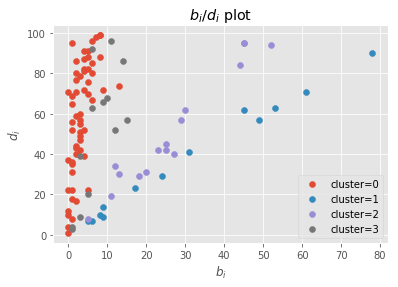

In [7]:
#plt.figure(figsize=(20,20))
for c in set(data[:,2]):
    data_c = data[data[:,2] == c]
    plt.scatter(data_c[:,0],data_c[:,1],label='cluster={}'.format(c))
    
plt.xlabel('$b_i$')
plt.ylabel('$d_i$')
plt.title('$b_i$/$d_i$ plot')
plt.legend()
plt.savefig('figures/T_3_1/Q2/data_plot.png')
    
plt.show()

---

In [11]:
gibbs = GibbsSampler(b,d,alpha)

In [12]:
samples, probs = gibbs.sampler(sample_count=1000,min=0,step=1,return_cluster_probs=True)

100%|██████████| 1000/1000 [02:13<00:00,  7.49it/s]


We draw $1000$ samples from the Gibbs sampler. The resulting Rand index and Mutual information plots suggest that the algorithm wasn't succesful in finding the right clusters for this model.

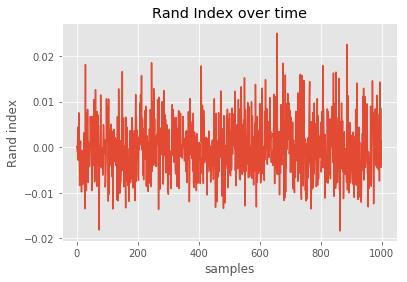

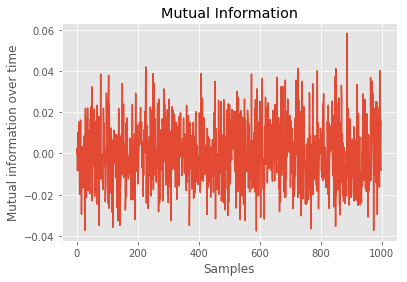

In [13]:
plt.plot( [ metrics.adjusted_rand_score(Z,sample) for sample in samples]);
plt.title('Rand Index over time')
plt.xlabel('samples')
plt.ylabel('Rand index')
plt.savefig('figures/T_3_1/Q2/rand_index.png')
plt.show()

plt.plot( [ metrics.adjusted_mutual_info_score(Z,sample) for sample in samples]);
plt.title('Mutual Information')
plt.xlabel('Samples')
plt.ylabel('Mutual information over time')
plt.savefig('figures/T_3_1/Q2/mutual_information.png')

plt.show()

Further investigation shows that the number of cluster is decreasing over time, but at some point it stops in a local optima. 

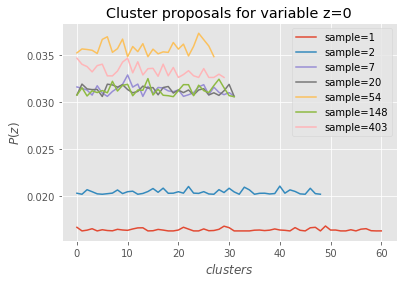

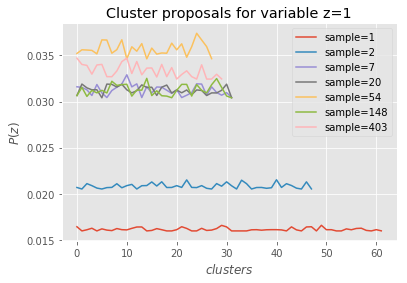

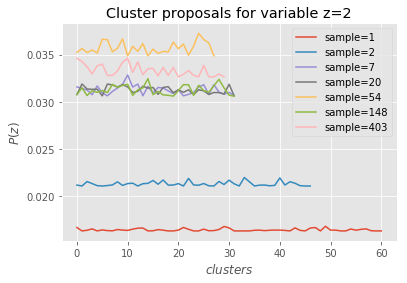

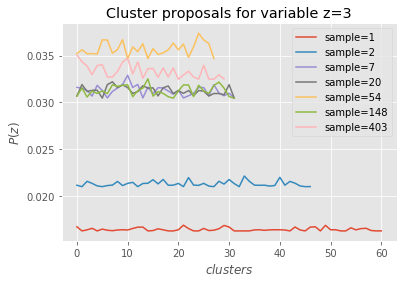

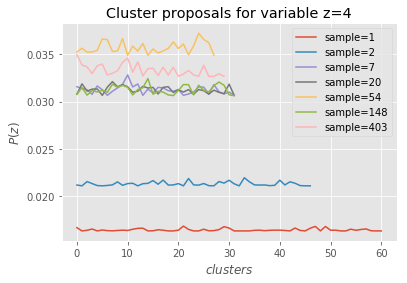

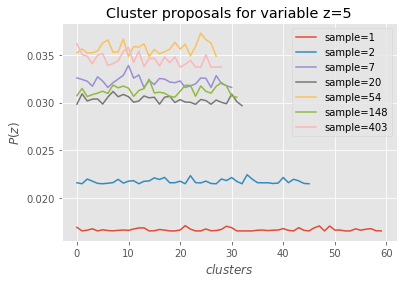

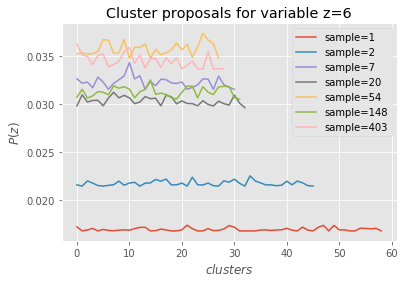

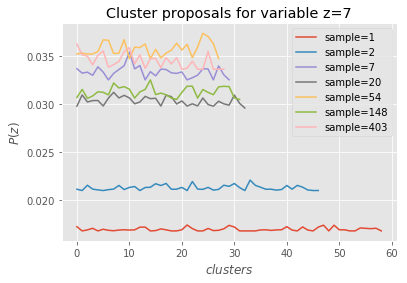

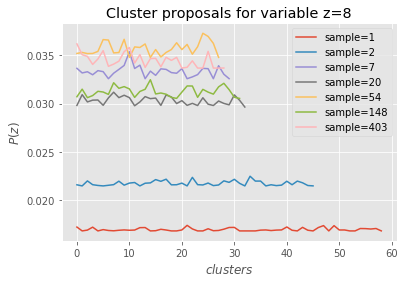

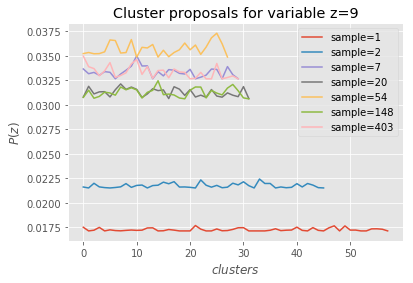

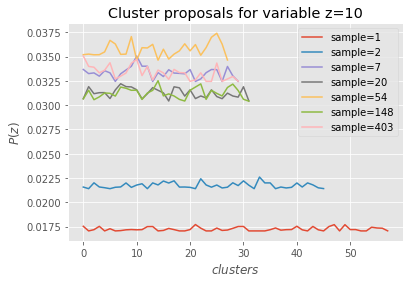

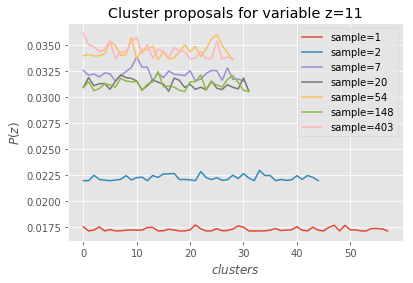

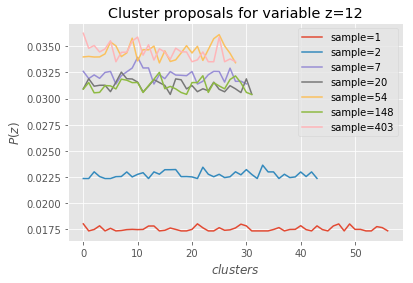

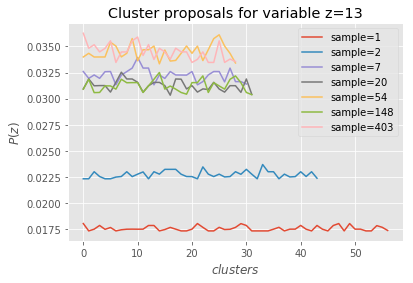

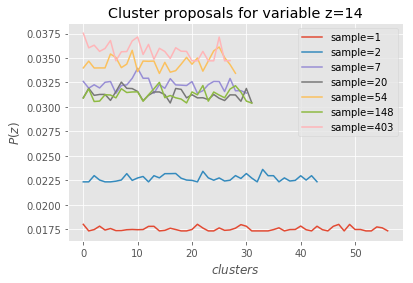

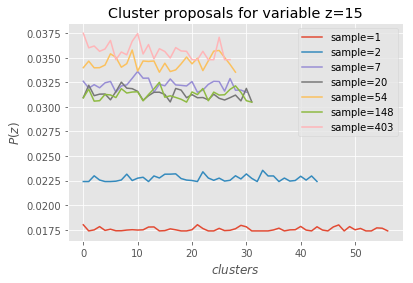

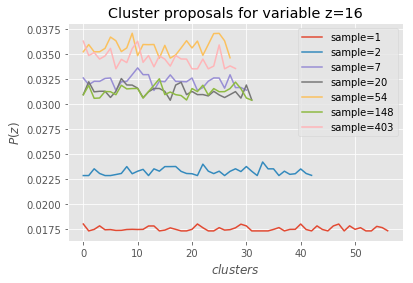

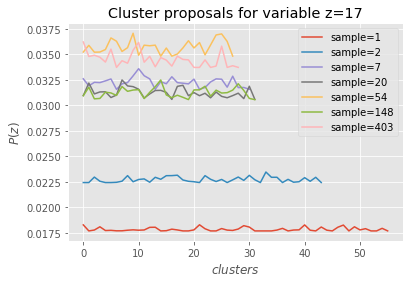

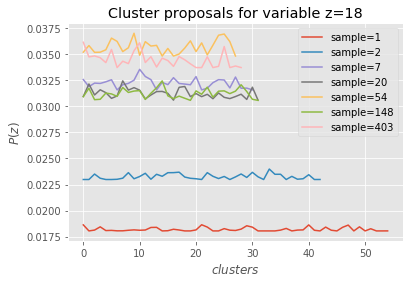

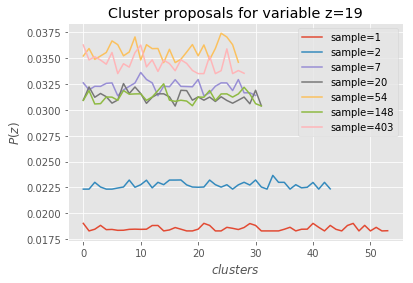

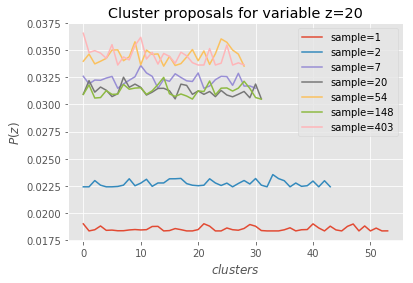

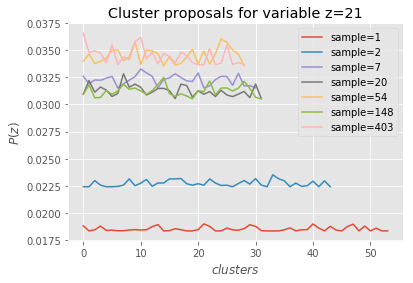

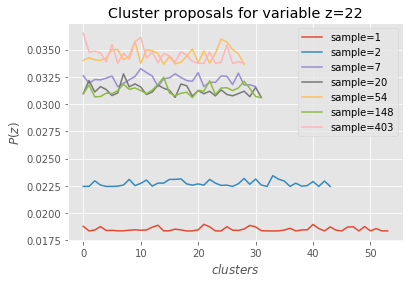

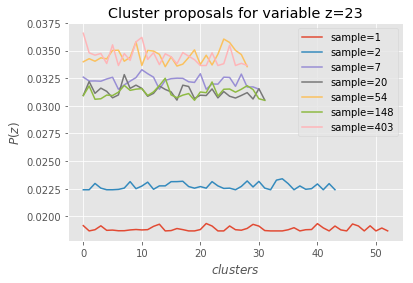

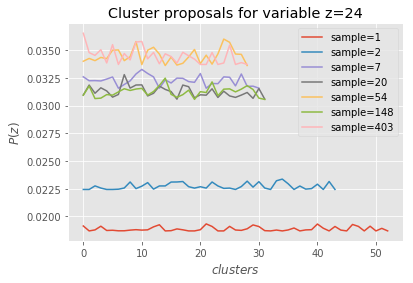

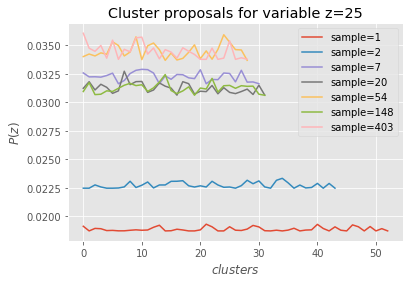

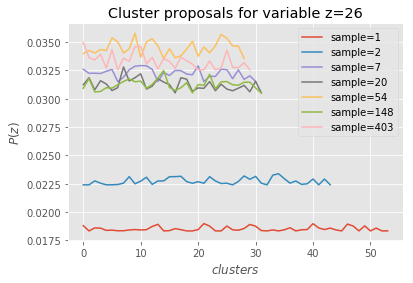

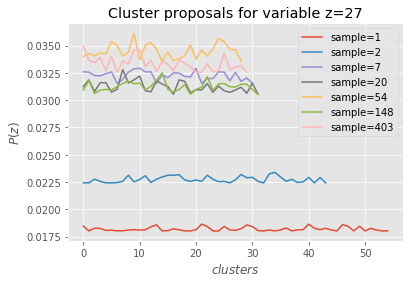

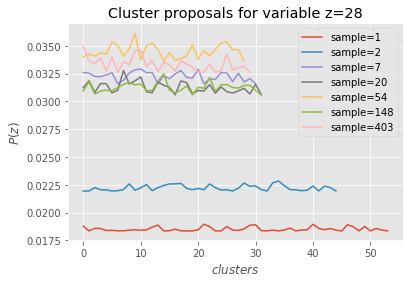

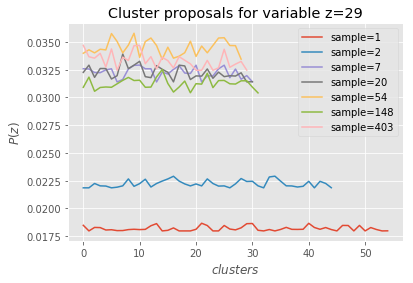

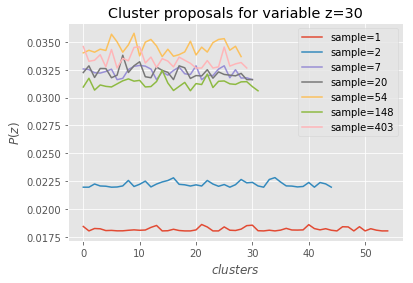

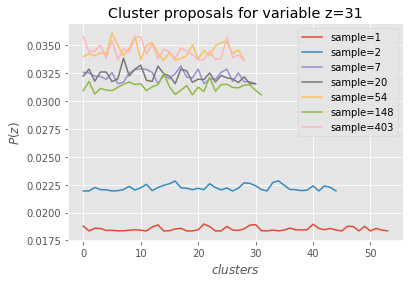

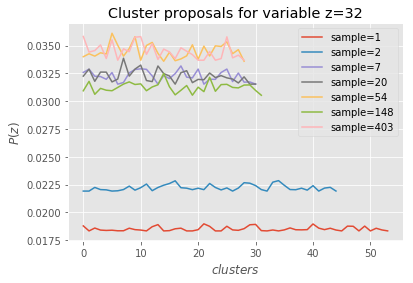

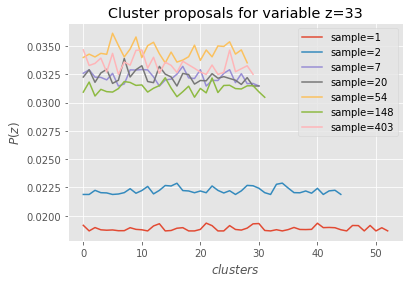

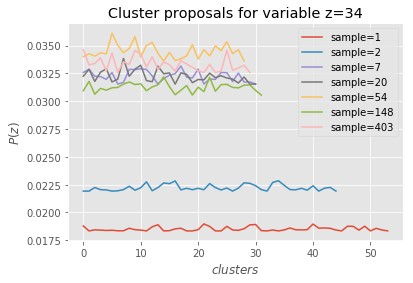

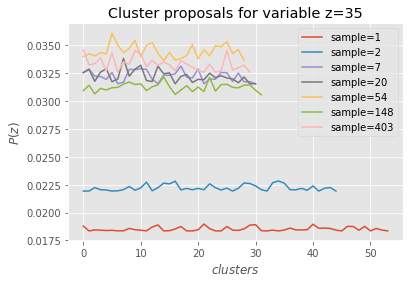

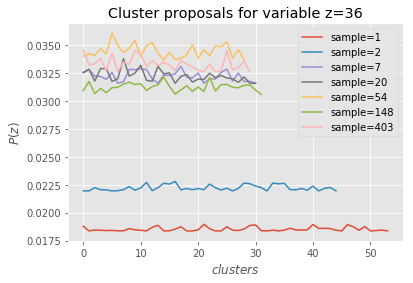

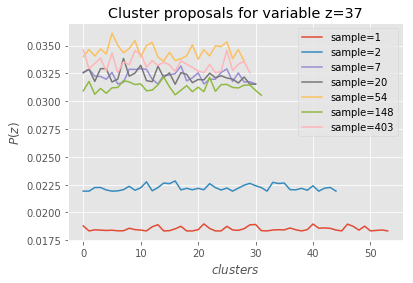

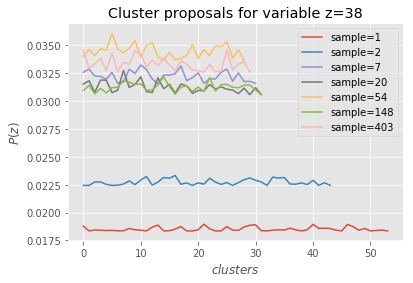

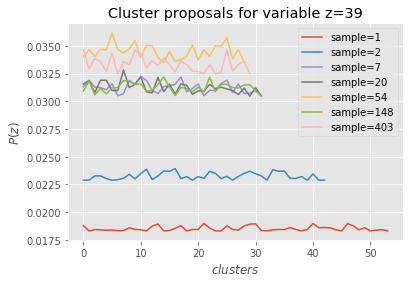

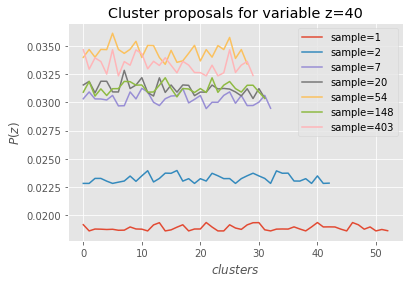

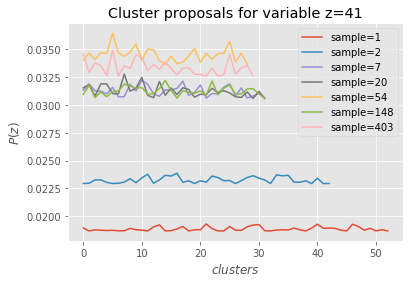

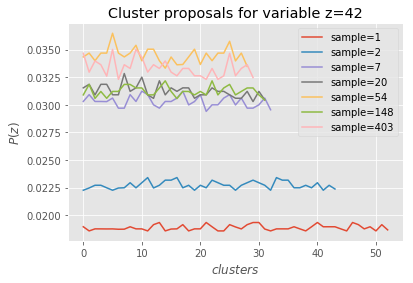

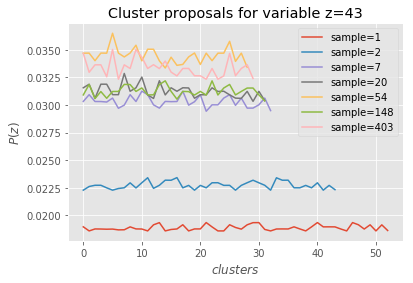

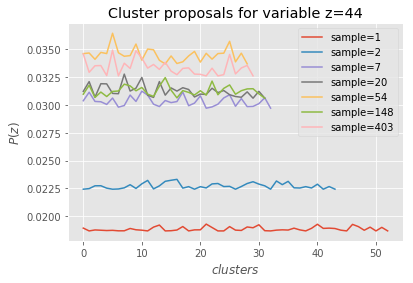

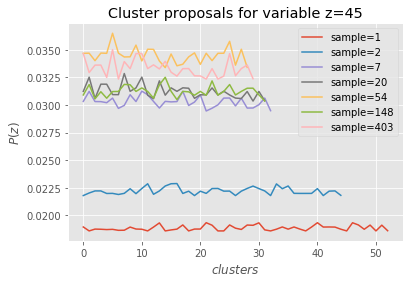

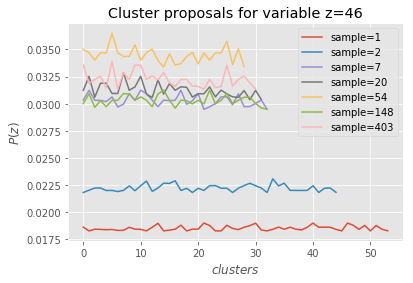

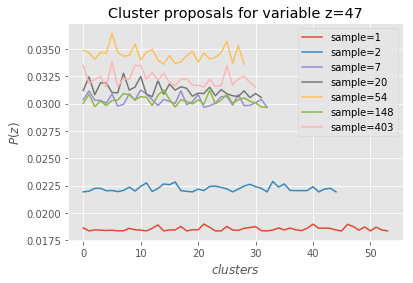

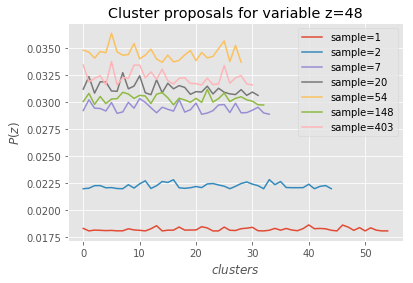

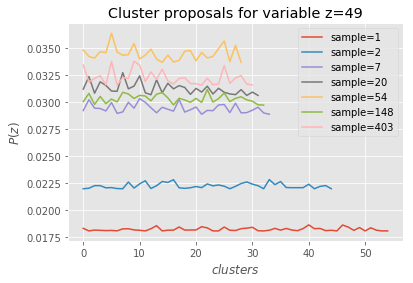

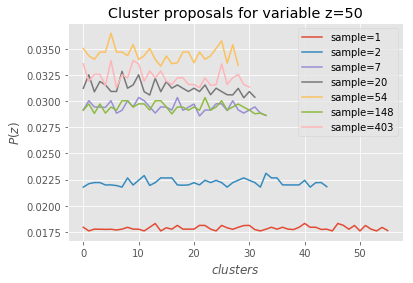

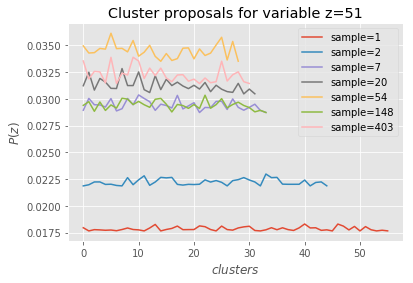

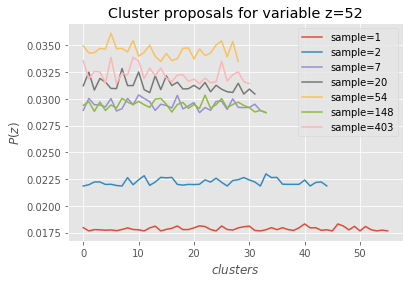

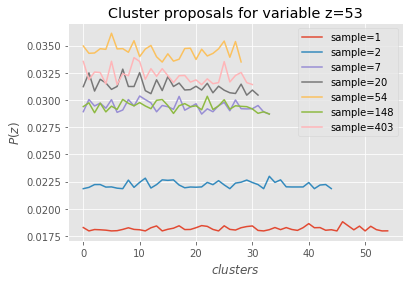

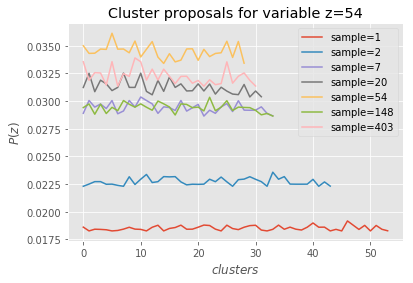

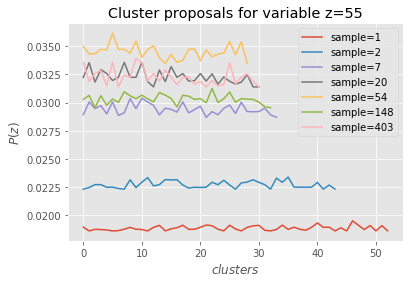

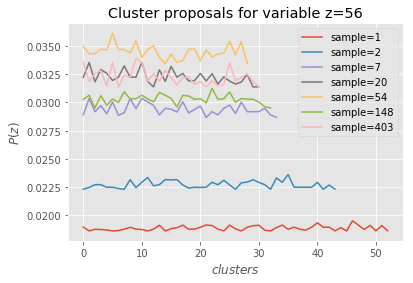

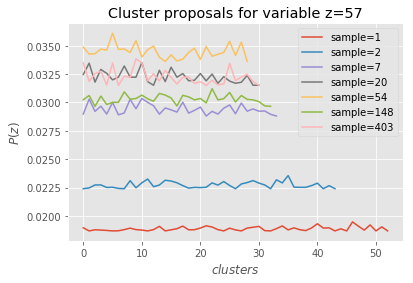

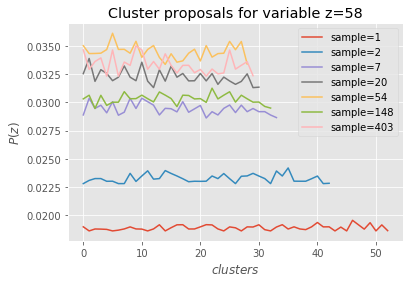

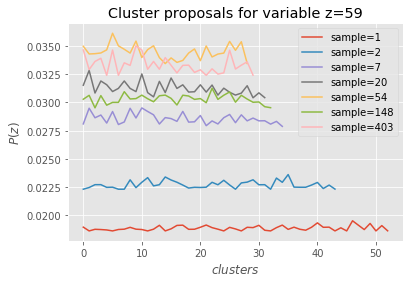

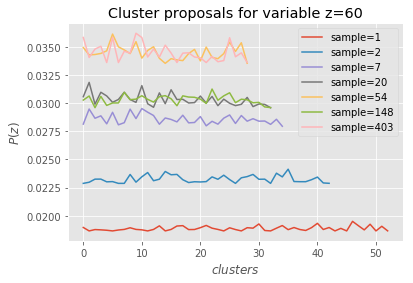

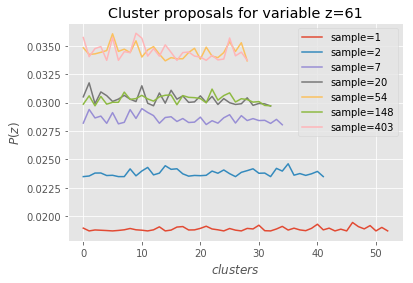

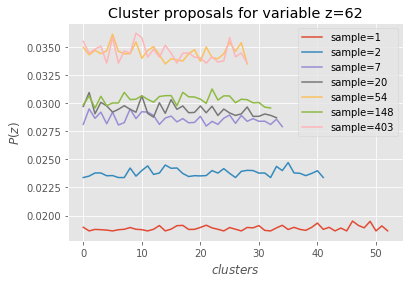

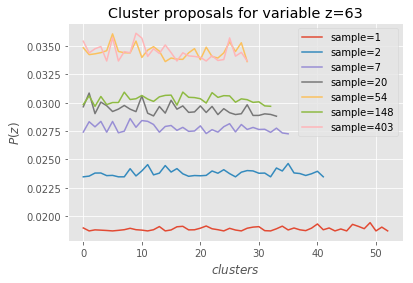

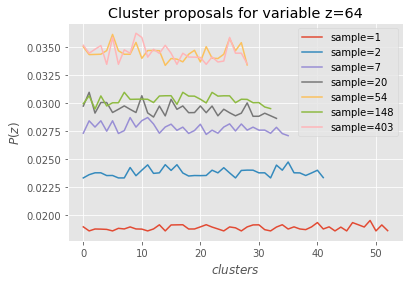

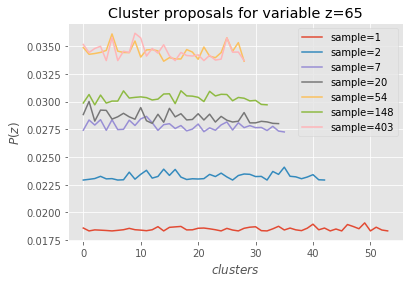

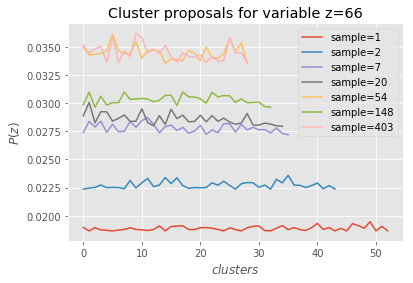

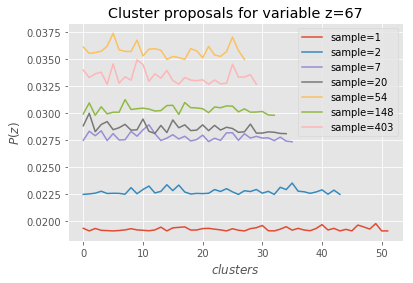

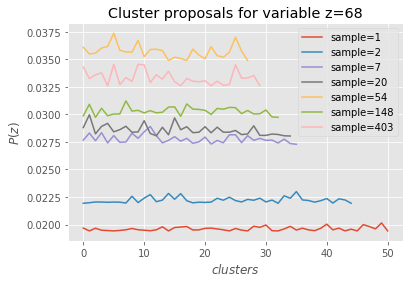

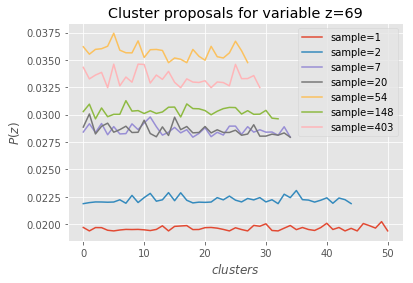

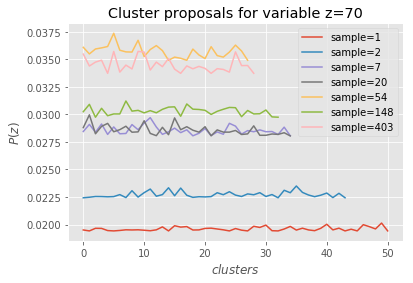

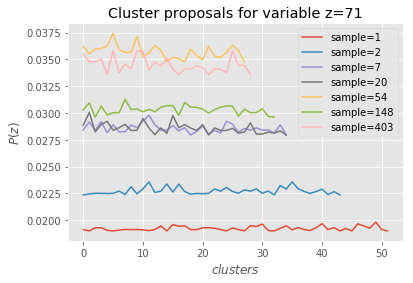

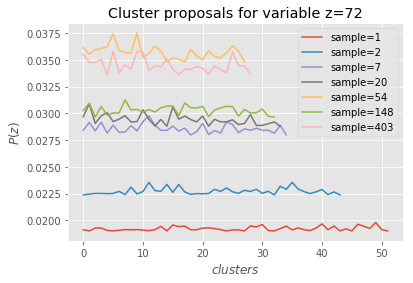

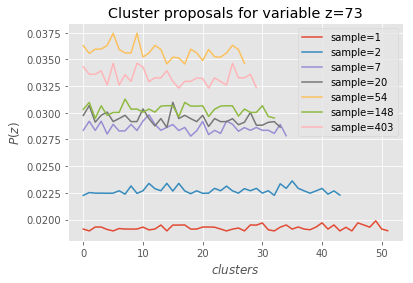

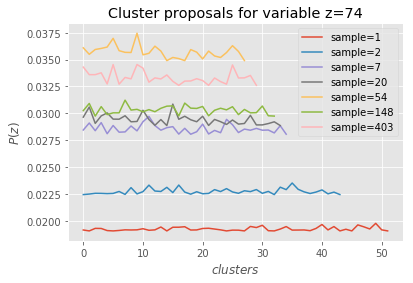

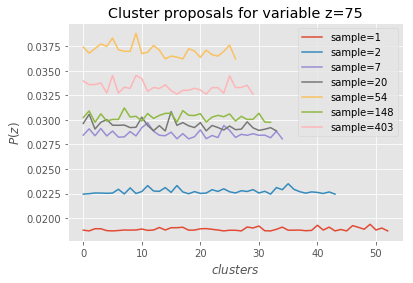

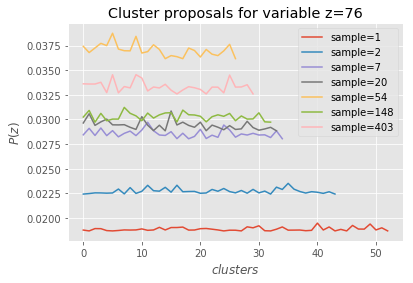

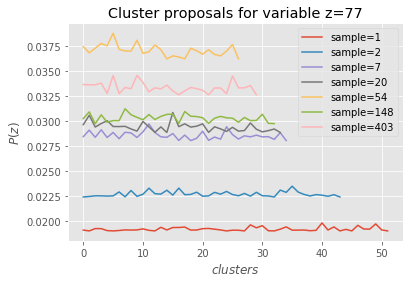

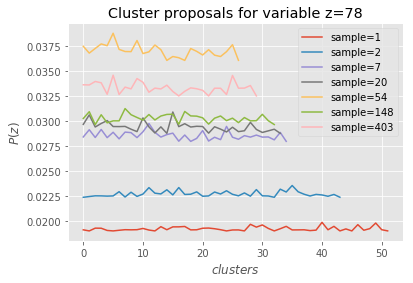

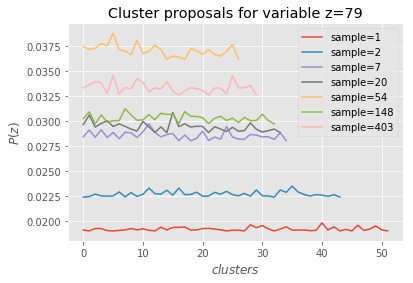

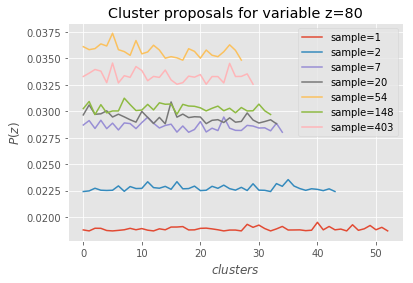

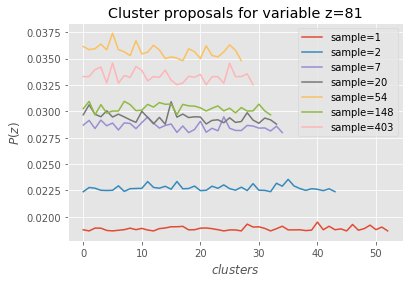

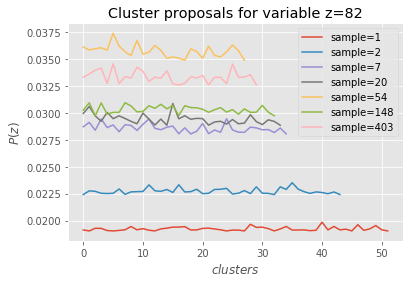

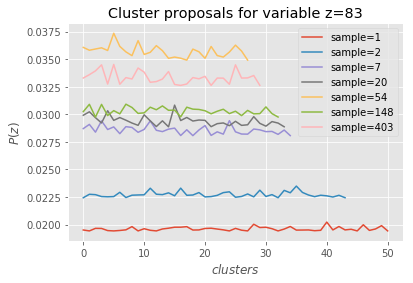

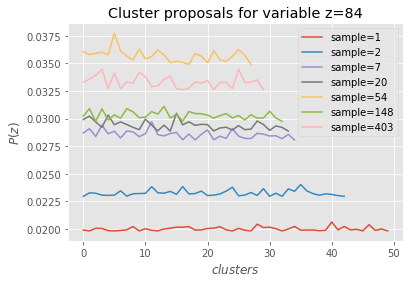

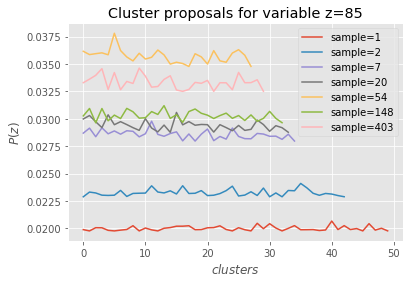

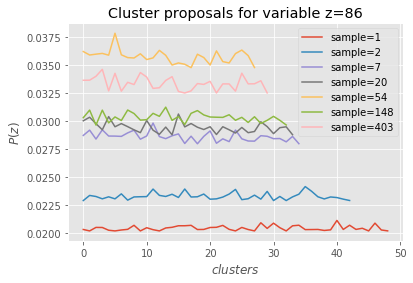

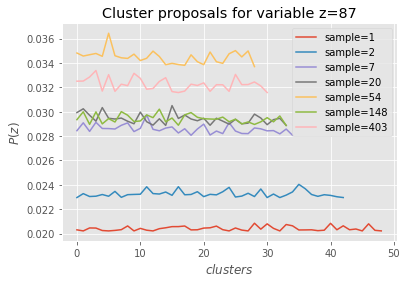

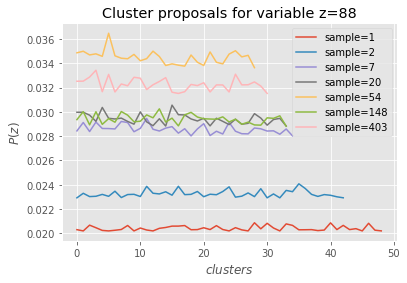

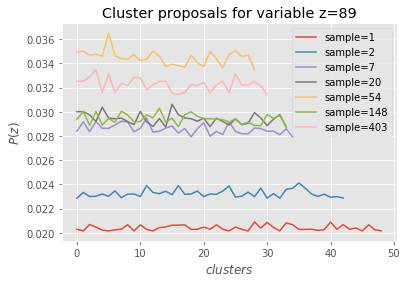

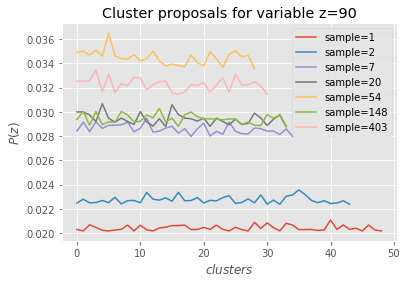

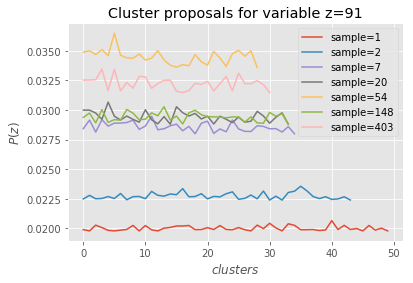

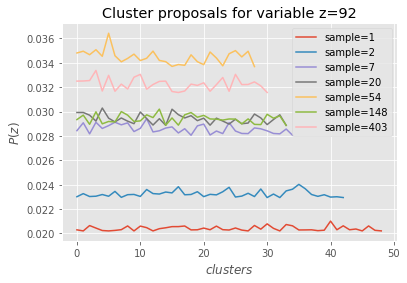

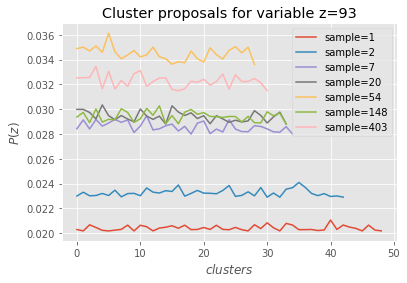

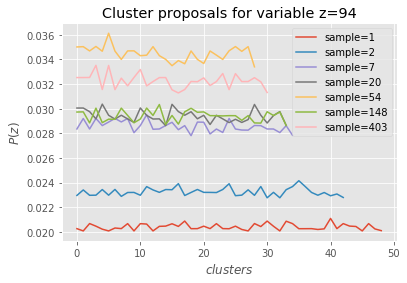

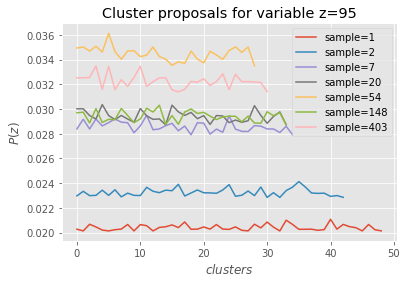

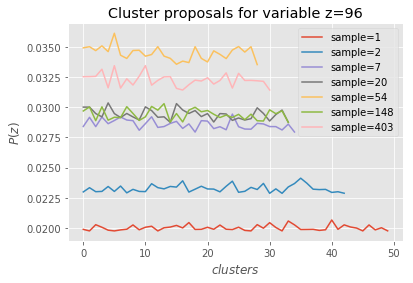

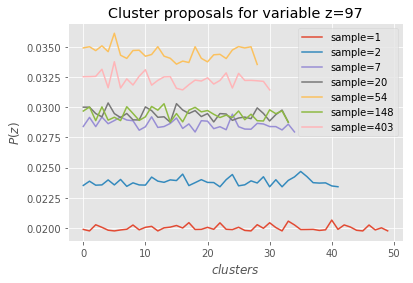

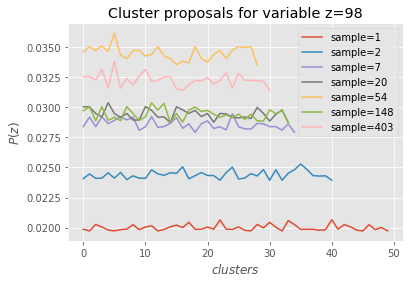

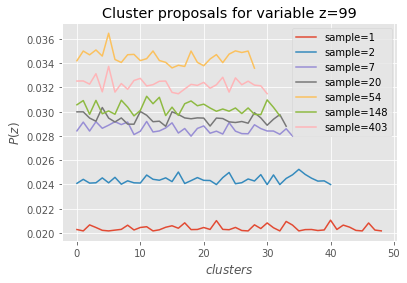

In [17]:
sample_count, var_count = probs.shape
log_index = int( np.round(np.log(sample_count)))
indices = map(lambda x: int(x), np.exp(np.arange(0,log_index)))

for vc in range(var_count):
    for sc in indices:
        plt.plot(probs[sc,vc],label='sample={}'.format(sc))
    plt.legend()
    
    plt.xlabel('$clusters$')
    plt.ylabel('$P(z)$')
    plt.title('Cluster proposals for variable z={}'.format(vc))
    plt.savefig('figures/T_3_1/Q2/sample_prob_{}.png'.format(vc))

    plt.show()

Possible improvements could be made by making a better initialisation rather then assigning a specific cluster to each point.

**Question 18:** The number of clusters can be controlled via the parameter $\alpha $. Study how the performance deteriorates with the increasing number of clusters. How is the number of data points affecting the performance?